# 데이터마이닝개론 프로젝트
# 통계데이터사이언스전공 202010936 전소영

In [1]:
# 필요한 패키지 가져오기기
import re
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7d8755aca530>)

In [3]:
#두 개의 열제목을 'ratings'와 'reviews'로 설정
total = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total))

전체 리뷰 개수 : 200000


In [4]:
# reviews 열에서 중복인 내용이 있다면 제거
total.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total))
total[-5:]

총 샘플의 수 : 199908


,ratings,reviews
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~
199999,5,아직 사용해보지도않았고 다른 제품을 써본적이없어서 잘 모르겠지만 ㅎㅎ 배송은 빨랐습니다


In [5]:
#평점이 4, 5인 리뷰에는 label에 1을, 평점이 1, 2인 리뷰에는 label 0을 저장
total['label'] = np.select([total.ratings > 3], [1], default=0)

In [6]:
# label이 1인 긍정적인 리뷰에서 12500개, label이 0인 부정적인 리뷰에서 12500개 랜덤으로 추출
total_pos = total[total['label'] == 1].sample(12500, random_state=33)
print("pos =", len(total_pos))
total_neg = total[total['label'] == 0].sample(12500, random_state=33)
print("neg =", len(total_neg))

pos = 12500
neg = 12500


In [7]:
# 랜덤으로 추출된 긍정 리뷰와 부정 리뷰를 하나로 병합
total = pd.concat([total_pos, total_neg])
total = total.reset_index(drop = True)
total

,ratings,reviews,label
0,5,완죤 대박입니다.튼튼하구 디자인두 굿. 좋은제품 감사합니다.,1
1,5,생각보다 맛있음 오리지날기준,1
2,5,첫 제품은 진짜 좋았는데 추가 구매한 제품이 문제가 있는지 응고력도 영... 먼지도...,1
3,5,진짜 너무 맛있어요 주변인들한테 다 추천헀어요 또사러 율겡용ㅎㅎ,1
4,5,진짜 거울 너무 이쁘고 집이 일단 엄청 고급스러워져서 너무 좋아요 ㅠ 정말 후회없는...,1
...,...,...,...
24995,2,생각보다 별로...우선사용이쉽지않고 깔끔히입기힘듬...그냥 사고 후회함,0
24996,2,제품은만족 배송 느리고 천일택배로 받았는데 택배기사는 물건 받고 물건 배송 안하고 ...,0
24997,2,너무사이즈가타이트해서 겨드랑이너무불편해서 남줘야겠네요.,0
24998,2,괜찮아용~~~꾸준히 믿고시키고잇슴돠,0


In [8]:
print(total.shape)
print(total.info())

(25000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ratings  25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   label    25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB
None


In [9]:
# 별점 개수
total['ratings'].value_counts()

5    10158
2     8124
1     4376
4     2342
Name: ratings, dtype: int64

In [10]:
val = pd.DataFrame(total['ratings'].value_counts())
val.loc[3] = [0]
val = val.sort_index()
val

,ratings
1,4376
2,8124
3,0
4,2342
5,10158


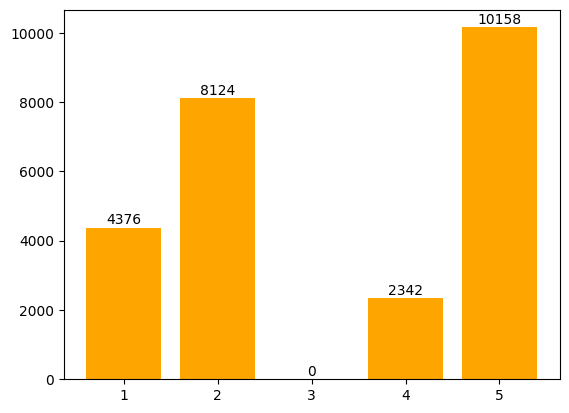

In [11]:
plt.bar(range(1,6), val['ratings'], color = 'orange')
for i in range(1,6):
  plt.text(i, val.loc[i, 'ratings'] + 100, val.loc[i, 'ratings'], ha='center')

In [12]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.6 MB/s eta 0:00:00


In [13]:
from konlpy.tag import Hannanum
tag = Hannanum()

In [14]:
#불용어를 지정하여 필요없는 단어들은 제거
stopwords = ['구매', '사용', '제품', '생각', '주문', '니다', '포장', '상품', '구입']

# konlpy 명사

In [15]:
# 문장의 명사를 추출
tokens = []
corpus = []
for i in range(len(total)):
  total.loc[i, 'reviews'] = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', total.loc[i, 'reviews'])
  word = tag.nouns(total.loc[i, 'reviews'])
  word = [w for w in word if w not in stopwords]
  word = [w for w in word if len(w) > 1]
  tokens.append(word)
  corpus.append(' '.join(word))
  if i % 5000 == 0 : print("i =", i)

i = 0
i = 5000
i = 10000
i = 15000
i = 20000


In [16]:
# 단어 행렬 만들기
g_dictionary = gensim.corpora.Dictionary(tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
dtm = vector.fit_transform(corpus).toarray()
col = g_dictionary.token2id.keys()
print(dtm.shape)
pd.DataFrame(dtm, columns=col)

(25000, 41358)


,감사,대박입니다튼튼하구,디자인두,완죤,좋은제품,오리지날기준,날리고ㅠ,문제,응고력,의사,...,깔끔히입기힘듬그냥,별로우선사용이쉽지않고,후회함,제품은만족,천일택배,겨드랑이너무불편해서,남줘야,너무사이즈가타이트해서,괜찮아용꾸준히,믿고시키고잇슴돠
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [17]:
# TF-IDF 행렬 만들기
tfidf_vectorizer = TfidfTransformer()
tf_idf = tfidf_vectorizer.fit_transform(dtm).toarray()
col = g_dictionary.token2id.keys()
print(tf_idf.shape)
pd.DataFrame(tf_idf, columns=col)

(25000, 41358)


,감사,대박입니다튼튼하구,디자인두,완죤,좋은제품,오리지날기준,날리고ㅠ,문제,응고력,의사,...,깔끔히입기힘듬그냥,별로우선사용이쉽지않고,후회함,제품은만족,천일택배,겨드랑이너무불편해서,남줘야,너무사이즈가타이트해서,괜찮아용꾸준히,믿고시키고잇슴돠
0,0.252169,0.534528,0.513756,0.478244,0.397527,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.561926,0.337519,0.561926,0.376117,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.57735,0.57735,0.57735,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
24996,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.262837,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.43759,0.43759,0.00000,0.00000,0.00000,0.000000,0.000000
24997,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.57735,0.57735,0.57735,0.000000,0.000000
24998,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.707107,0.707107


In [18]:
# 학습을 위한 데이터 분리
X = tf_idf
y=total['label']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=425)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17500, 41358) (17500,) (7500, 41358) (7500,)


In [19]:
# 모형 적합과 예측
lr = LogisticRegression(random_state = 114, max_iter = 500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [20]:
# 성능평가지표 확인
a = accuracy_score(y_test, y_pred)
p = precision_score(y_test, y_pred)
r =recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print('Accuracy: %.2f' % a,', Precision: %.2f' % p, ', Recall: %.2f' % r, ', F1: %.2f' % f1 )
tr1 = pd.DataFrame([a, p, r, f1])

Accuracy: 0.73 , Precision: 0.79 , Recall: 0.62 , F1: 0.70


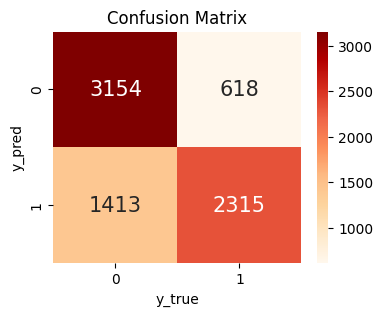

In [21]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      3772
           1       0.79      0.62      0.70      3728

    accuracy                           0.73      7500
   macro avg       0.74      0.73      0.73      7500
weighted avg       0.74      0.73      0.73      7500



[[ 4.41696346  0.07216465  0.18777758 ... -0.2111562   0.
   0.        ]]


<BarContainer object of 41358 artists>

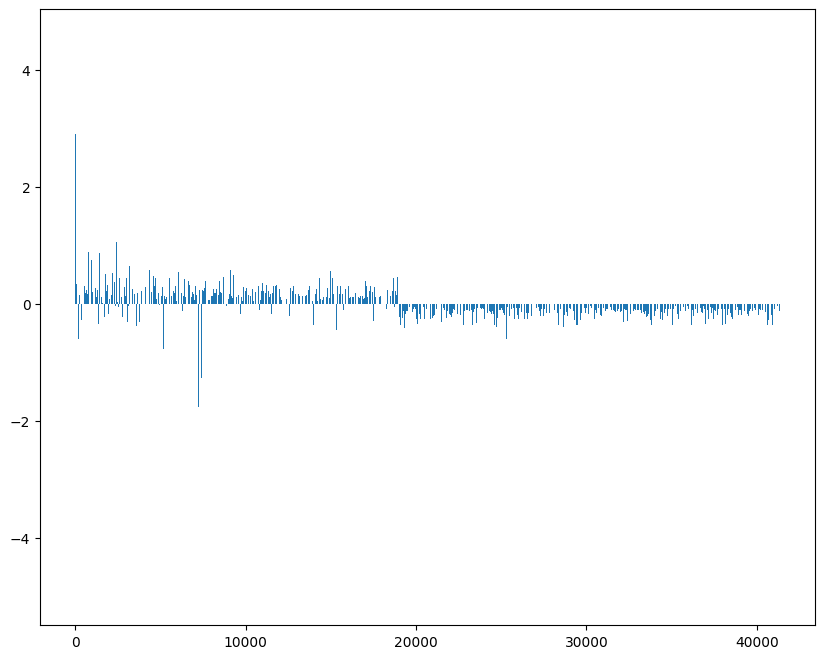

In [23]:
# 추청계수 그래프로 표현
print(lr.coef_)
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [24]:
# id를 단어로 변환
id_to_word = {v: k for k, v in vector.vocabulary_.items()}
print(id_to_word[5])

오리지날기준


In [25]:
coef_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_neg_index = coef_index[:10]
coef_pos_index = coef_index[-10:]
print(coef_pos_index[-3:])
print(coef_neg_index [:3])
print('긍정리뷰 키워드: ', id_to_word[coef_pos_index[-1][1]],id_to_word[coef_pos_index[-2][1]])
print('부정리뷰 키워드: ', id_to_word[coef_neg_index[0][1]],id_to_word[coef_neg_index[1][1]])

[(4.416963464205188, 0), (4.436873752494431, 586), (4.560253106480529, 43)]
[(-5.019670943372954, 729), (-4.81746441335805, 3258), (-4.073671207049125, 868)]
긍정리뷰 키워드:  만족 ㅎㅎ
부정리뷰 키워드:  반품 실망


In [26]:
pos_top_word=[]
pos_top_coef=[]
pos_top_score=[]
for coef in coef_pos_index:
    pos_top_word.append(id_to_word[coef[1]])
    pos_top_coef.append(coef[0])
    pos_top_score.append(np.exp(coef[0]))

neg_top_word=[]
neg_top_coef=[]
neg_top_score=[]
for coef in coef_neg_index:
    neg_top_word.append(id_to_word[coef[1]])
    neg_top_coef.append(coef[0])
    neg_top_score.append(np.exp(coef[0]))

pos = pd.DataFrame({'단어':pos_top_word, '회귀계수':pos_top_coef, '단위변화량':pos_top_score})
neg = pd.DataFrame({'단어':neg_top_word, '회귀계수':neg_top_coef, '단위변화량':neg_top_score})

In [27]:
pos.sort_values('단위변화량', ascending=False)

,단어,회귀계수,단위변화량
9,만족,4.560253,95.607676
8,ㅎㅎ,4.436874,84.510328
7,감사,4.416963,82.844343
6,깔끔,4.054172,57.637409
5,최고,3.770618,43.406896
4,튼튼,3.237881,25.479686
3,빠른배송,3.163454,23.652143
2,가성비,3.089865,21.974121
1,재구,2.901417,18.199911
0,적당,2.887321,17.945174


In [28]:
neg

,단어,회귀계수,단위변화량
0,반품,-5.019671,0.006607
1,실망,-4.817464,0.008087
2,불편,-4.073671,0.017015
3,최악,-3.721897,0.024188
4,교환,-3.643531,0.026160
5,ㅠㅠ,-3.183849,0.041426
6,ㅡㅡ,-3.023398,0.048636
7,ㅜㅜ,-2.721866,0.065752
8,불량,-2.611920,0.073394
9,연락,-2.469855,0.084597


In [29]:
print("pos_top_word =", pos_top_word)
print("pos_top_coef =", pos_top_coef)
print("neg_top_word =", neg_top_word)
print("neg_top_coef =", neg_top_coef)

pos_top_word = ['적당', '재구', '가성비', '빠른배송', '튼튼', '최고', '깔끔', '감사', 'ㅎㅎ', '만족']
pos_top_coef = [2.8873212010874707, 2.9014166995093875, 3.0898654313313716, 3.163453733505539, 3.2378814949665276, 3.770618324230375, 4.054171811226726, 4.416963464205188, 4.436873752494431, 4.560253106480529]
neg_top_word = ['반품', '실망', '불편', '최악', '교환', 'ㅠㅠ', 'ㅡㅡ', 'ㅜㅜ', '불량', '연락']
neg_top_coef = [-5.019670943372954, -4.81746441335805, -4.073671207049125, -3.7218969027911197, -3.6435305936201186, -3.1838493840729716, -3.0233980189700196, -2.7218659543557058, -2.611919712123703, -2.469855065659129]


# 긍정 부정 키워드 그래프 (명사)

In [30]:
# 그래프에 한글을 표시할 수 있도록 설치, 설치 후 런타임 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and direc

In [1]:
pos_top_word = ['적당', '재구', '가성비', '빠른배송', '튼튼', '최고', '깔끔', '감사', 'ㅎㅎ', '만족']
pos_top_coef = [2.8873212010874707, 2.9014166995093875, 3.0898654313313716, 3.163453733505539, 3.2378814949665276, 3.770618324230375, 4.054171811226726, 4.416963464205188, 4.436873752494431, 4.560253106480529]
neg_top_word = ['반품', '실망', '불편', '최악', '교환', 'ㅠㅠ', 'ㅡㅡ', 'ㅜㅜ', '불량', '연락']
neg_top_coef = [-5.019670943372954, -4.81746441335805, -4.073671207049125, -3.7218969027911197, -3.6435305936201186, -3.1838493840729716, -3.0233980189700196, -2.7218659543557058, -2.611919712123703, -2.469855065659129]

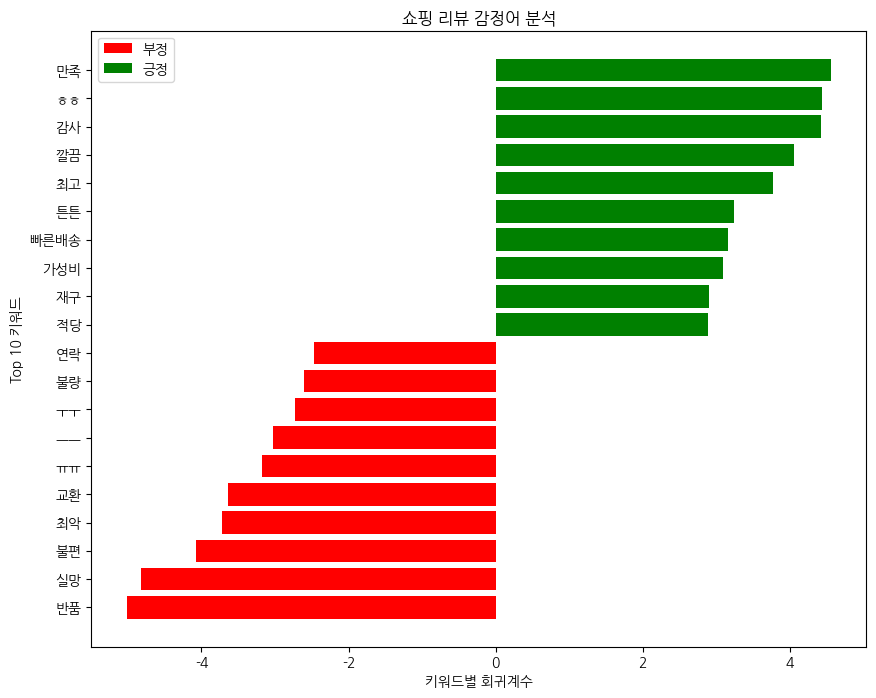

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=[10, 8])
plt.barh(neg_top_word, neg_top_coef, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_coef, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 회귀계수',)
plt.ylabel('Top 10 키워드')
plt.title('쇼핑 리뷰 감정어 분석')
plt.show()

# konlpy 형태소

In [15]:
# 문장의 형태소를 추출
tokens = []
corpus = []
for i in range(len(total)):
  total.loc[i, 'reviews'] = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', total.loc[i, 'reviews'])
  word = tag.pos(total.loc[i, 'reviews'])
  word = [i[0] for i in word if ('I' in i[1] or 'M' in i[1] or 'N' in i[1] or 'P' in i[1] or 'X' in i[1])]
  word = [w for w in word if w not in stopwords]
  word = [w for w in word if len(w) > 1]
  tokens.append(word)
  corpus.append(' '.join(word))
  if i % 5000 == 0 : print("i =", i)

i = 0
i = 5000
i = 10000
i = 15000
i = 20000


In [16]:
# 단어 행렬 만들기
g_dictionary = gensim.corpora.Dictionary(tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
dtm = vector.fit_transform(corpus).toarray()
col = g_dictionary.token2id.keys()
print(dtm.shape)
pd.DataFrame(dtm, columns=col)

(25000, 42664)


,감사,대박입니다튼튼하구,디자인두,완죤,좋은제품,맛있,오리지날기준,그래도,날리고ㅠ,만들,...,깔끔히입기힘듬그냥,별로우선사용이쉽지않고,후회함,제품은만족,천일택배,겨드랑이너무불편해서,남줘야,너무사이즈가타이트해서,괜찮아용꾸준히,믿고시키고잇슴돠
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [17]:
# TF-IDF 행렬 만들기
tfidf_vectorizer = TfidfTransformer()
tf_idf = tfidf_vectorizer.fit_transform(dtm).toarray()
col = g_dictionary.token2id.keys()
print(tf_idf.shape)
pd.DataFrame(tf_idf, columns=col)

(25000, 42664)


,감사,대박입니다튼튼하구,디자인두,완죤,좋은제품,맛있,오리지날기준,그래도,날리고ㅠ,만들,...,깔끔히입기힘듬그냥,별로우선사용이쉽지않고,후회함,제품은만족,천일택배,겨드랑이너무불편해서,남줘야,너무사이즈가타이트해서,괜찮아용꾸준히,믿고시키고잇슴돠
0,0.252169,0.534528,0.513756,0.478244,0.397527,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.403646,0.914915,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.282139,0.512646,0.297645,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.216868,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.57735,0.57735,0.57735,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
24996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.425427,0.425427,0.00000,0.00000,0.00000,0.000000,0.000000
24997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.57735,0.57735,0.57735,0.000000,0.000000
24998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.707107,0.707107


In [18]:
# 학습을 위한 데이터 분리
X = tf_idf
y=total['label']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=425)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17500, 42664) (17500,) (7500, 42664) (7500,)


In [19]:
# 모형 적합과 예측
lr = LogisticRegression(random_state = 114, max_iter = 500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [20]:
# 성능평가지표 확인
a = accuracy_score(y_test, y_pred)
p = precision_score(y_test, y_pred)
r =recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print('Accuracy: %.2f' % a,', Precision: %.2f' % p, ', Recall: %.2f' % r, ', F1: %.2f' % f1 )
tr1 = pd.DataFrame([a, p, r, f1])

Accuracy: 0.79 , Precision: 0.83 , Recall: 0.72 , F1: 0.77


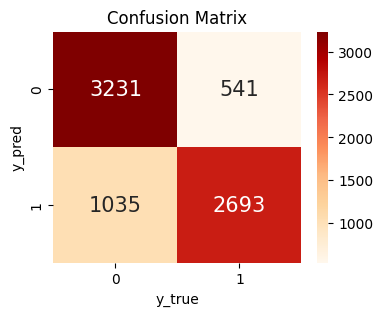

In [21]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.80      3772
           1       0.83      0.72      0.77      3728

    accuracy                           0.79      7500
   macro avg       0.80      0.79      0.79      7500
weighted avg       0.79      0.79      0.79      7500



[[ 4.20734021  0.07703911  0.13750088 ... -0.21462852  0.
   0.        ]]


<BarContainer object of 42664 artists>

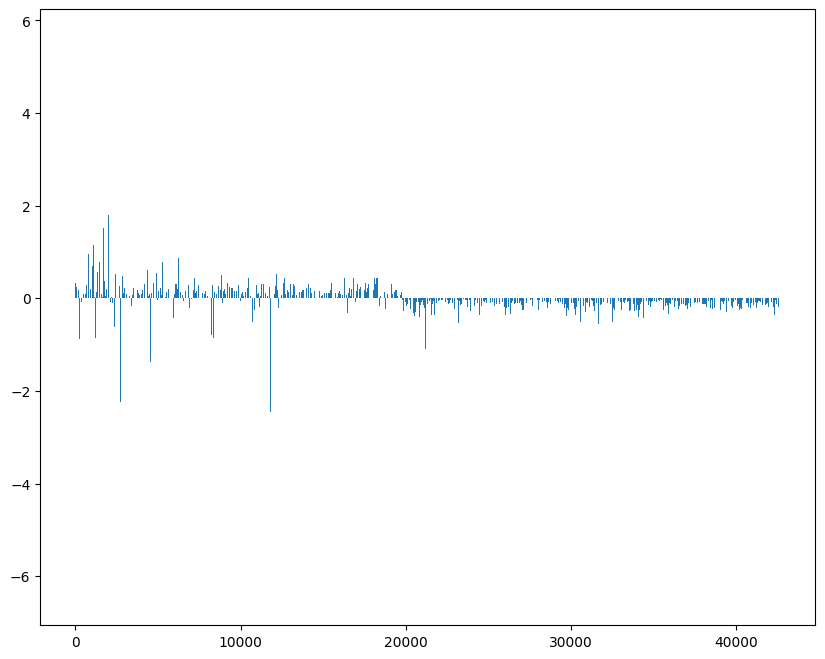

In [23]:
# 추청계수 그래프로 표현
print(lr.coef_)
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [24]:
# id를 단어로 변환
id_to_word = {v: k for k, v in vector.vocabulary_.items()}
print(id_to_word[5])

맛있


In [25]:
coef_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_neg_index = coef_index[:10]
coef_pos_index = coef_index[-10:]
print(coef_pos_index[-3:])
print(coef_neg_index [:3])
print('긍정리뷰 키워드: ', id_to_word[coef_pos_index[-1][1]],id_to_word[coef_pos_index[-2][1]])
print('부정리뷰 키워드: ', id_to_word[coef_neg_index[0][1]],id_to_word[coef_neg_index[1][1]])

[(4.6144169364774745, 72), (4.631878185402803, 58), (5.634298254533329, 5)]
[(-6.455495694214971, 34), (-4.638978413224708, 3608), (-4.223587738366297, 2115)]
긍정리뷰 키워드:  맛있 만족
부정리뷰 키워드:  그냥 실망


In [26]:
pos_top_word=[]
pos_top_coef=[]
pos_top_score=[]
for coef in coef_pos_index:
    pos_top_word.append(id_to_word[coef[1]])
    pos_top_coef.append(coef[0])
    pos_top_score.append(np.exp(coef[0]))

neg_top_word=[]
neg_top_coef=[]
neg_top_score=[]
for coef in coef_neg_index:
    neg_top_word.append(id_to_word[coef[1]])
    neg_top_coef.append(coef[0])
    neg_top_score.append(np.exp(coef[0]))

pos = pd.DataFrame({'단어':pos_top_word, '회귀계수':pos_top_coef, '단위변화량':pos_top_score})
neg = pd.DataFrame({'단어':neg_top_word, '회귀계수':neg_top_coef, '단위변화량':neg_top_score})

In [27]:
pos.sort_values('단위변화량', ascending=False)

,단어,회귀계수,단위변화량
9,맛있,5.634298,279.862456
8,만족,4.631878,102.706785
7,편하,4.614417,100.928963
6,빠르,4.562513,95.824002
5,ㅎㅎ,4.301951,73.843707
4,감사,4.207340,67.177623
3,깔끔,4.174375,64.999182
2,이쁘,3.794684,44.464180
1,예쁘,3.750340,42.535543
0,최고,3.632289,37.799251


In [28]:
neg

,단어,회귀계수,단위변화량
0,그냥,-6.455496,0.001572
1,실망,-4.638978,0.009668
2,못하,-4.223588,0.014646
3,불편,-3.962375,0.019018
4,별로,-3.873688,0.020782
5,안되,-3.537674,0.029081
6,아니,-3.409933,0.033043
7,반품,-3.394471,0.033558
8,최악,-3.354846,0.034915
9,버리,-3.161788,0.042350


In [29]:
print("pos_top_word =", pos_top_word)
print("pos_top_coef =", pos_top_coef)
print("neg_top_word =", neg_top_word)
print("neg_top_coef =", neg_top_coef)

pos_top_word = ['최고', '예쁘', '이쁘', '깔끔', '감사', 'ㅎㅎ', '빠르', '편하', '만족', '맛있']
pos_top_coef = [3.632289296474853, 3.75034002804014, 3.7946839285845595, 4.17437467934042, 4.207340205043373, 4.301950795837387, 4.562513194919941, 4.6144169364774745, 4.631878185402803, 5.634298254533329]
neg_top_word = ['그냥', '실망', '못하', '불편', '별로', '안되', '아니', '반품', '최악', '버리']
neg_top_coef = [-6.455495694214971, -4.638978413224708, -4.223587738366297, -3.962374549131177, -3.873687938272819, -3.537674134739032, -3.4099329225438986, -3.3944712069861716, -3.3548460491147307, -3.1617879088693064]


# 긍정 부정 키워드 그래프 (형태소)

In [30]:
# 그래프에 한글을 표시할 수 있도록 설치, 설치 후 런타임 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
pos_top_word = ['최고', '예쁘', '이쁘', '깔끔', '감사', 'ㅎㅎ', '빠르', '편하', '만족', '맛있']
pos_top_coef = [3.632289296474853, 3.75034002804014, 3.7946839285845595, 4.17437467934042, 4.207340205043373, 4.301950795837387, 4.562513194919941, 4.6144169364774745, 4.631878185402803, 5.634298254533329]
neg_top_word = ['그냥', '실망', '못하', '불편', '별로', '안되', '아니', '반품', '최악', '버리']
neg_top_coef = [-6.455495694214971, -4.638978413224708, -4.223587738366297, -3.962374549131177, -3.873687938272819, -3.537674134739032, -3.4099329225438986, -3.3944712069861716, -3.3548460491147307, -3.1617879088693064]

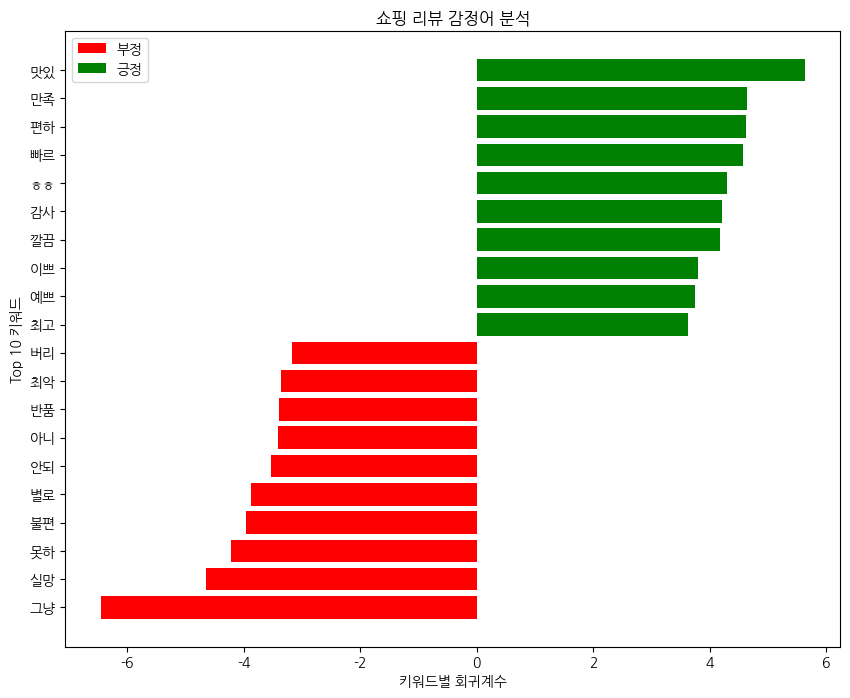

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=[10, 8])
plt.barh(neg_top_word, neg_top_coef, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_coef, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 회귀계수',)
plt.ylabel('Top 10 키워드')
plt.title('쇼핑 리뷰 감정어 분석')
plt.show()